In [1]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import random

In [2]:
G=8
W=5
n=40
model = AbstractModel()
model.N =Param(mutable=True, initialize=n) 
model.i = RangeSet(1,model.N)
model.j=Set(initialize=model.i)
model.w = RangeSet(1,W)
model.g = RangeSet(1,G)
model.x = Var(model.i,model.g,model.w,initialize=0,domain=Binary)
model.U = Var(model.i,model.j,model.g,model.w,bounds=(0,1),domain=NonNegativeReals)

def rue_c1(model,g,w):
    return sum(model.x[i,g,w] for i in model.i)==int(n/G) 
model.C1 =Constraint(model.g,model.w,rule=rue_c1)

def rue_c2(model,i,w):
    return sum(model.x[i,g,w] for g in model.g)==1 
model.C2 =Constraint(model.i,model.w,rule=rue_c2)

def rue_c3(model,i,j,g,w):
    if i>j:
        return model.x[i,g,w] + model.x[j,g,w] -1<=model.U[i,j,g,w]
    else:
        return Constraint.Skip
model.C3 =Constraint(model.i,model.j,model.g,model.w,rule=rue_c3)

def rue_c3B(model,i,j,g,w):
    if i>j:
        return model.x[j,g,w] >=model.U[i,j,g,w]
    else:
        return Constraint.Skip
model.C3B =Constraint(model.i,model.j,model.g,model.w,rule=rue_c3B)

def rue_c3C(model,i,j,g,w):
    if i>j:
        return model.x[i,g,w] >=model.U[i,j,g,w]
    else:
        return Constraint.Skip
model.C3C =Constraint(model.i,model.j,model.g,model.w,rule=rue_c3C)

def rue_c4(model,i,j):
    if i>j:
        return sum(model.U[i,j,g,w] for g in model.g for w in model.w )<=1
    else:
        return Constraint.Skip
model.C4 =Constraint(model.i,model.j,rule=rue_c4)

def rule_OF(model):
    return sum(model.x[i,g,w] for i in model.i for g in model.g for w in model.w)
model.obj = Objective(rule=rule_OF, sense=minimize)


In [3]:
instance = model.create_instance()

In [4]:
opt = SolverFactory('gurobi')
results=opt.solve(instance)

from pyomo.opt import SolverStatus, TerminationCondition
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
     print ("this is feasible and optimal")
elif results.solver.termination_condition == TerminationCondition.infeasible:
     print ("do something about it? or exit?")
else:
     print (str(results.solver))

this is feasible and optimal


In [5]:
K=['cyan','orange','tomato','deeppink','silver','greenyellow','teal','royalblue'];

K=plt.cm.tab10  # define the colormap
K=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
cmap = plt.cm.Set3  # define the colormap
K = [cmap(i) for i in range(20)]
M=['o', '+', 'x', '*', '.', 'X','|','s']

'''plt.figure(figsize=(12,8))
for w in instance.w:
    res=[]
    for g in instance.g:
        a=[i for i in instance.i  if value(instance.x[i,g,w]) >0 ]
        res.append(a)
        for p in range(4):
            plt.scatter(-1+g*5+0.8*p,w,s=10*a[p], marker=M[a[p]%8] , c=K[a[p]%5]   )

#plt.xlim(80,280)
plt.grid()
plt.xlabel('Group Number', fontweight='bold', fontsize=14)
plt.ylabel('Week Number', fontweight='bold', fontsize=14)
plt.xticks([i*5 for i in range(1,9)],[str(i) for i in range(1,9)] ,fontweight='bold', fontsize=12)
plt.yticks([i for i in range(1,6)],fontweight='bold', fontsize=12)
plt.rc('axes',edgecolor='w')'''

"plt.figure(figsize=(12,8))\nfor w in instance.w:\n    res=[]\n    for g in instance.g:\n        a=[i for i in instance.i  if value(instance.x[i,g,w]) >0 ]\n        res.append(a)\n        for p in range(4):\n            plt.scatter(-1+g*5+0.8*p,w,s=10*a[p], marker=M[a[p]%8] , c=K[a[p]%5]   )\n\n#plt.xlim(80,280)\nplt.grid()\nplt.xlabel('Group Number', fontweight='bold', fontsize=14)\nplt.ylabel('Week Number', fontweight='bold', fontsize=14)\nplt.xticks([i*5 for i in range(1,9)],[str(i) for i in range(1,9)] ,fontweight='bold', fontsize=12)\nplt.yticks([i for i in range(1,6)],fontweight='bold', fontsize=12)\nplt.rc('axes',edgecolor='w')"

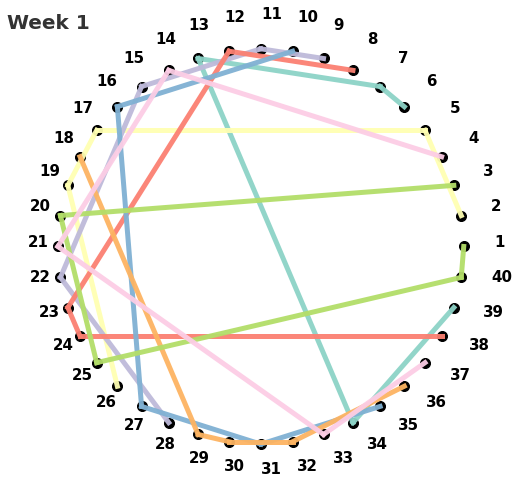

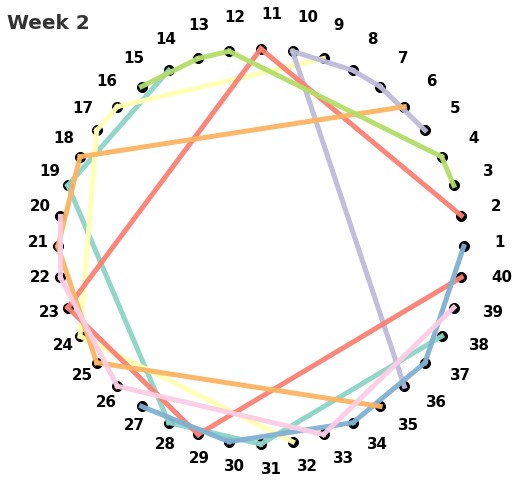

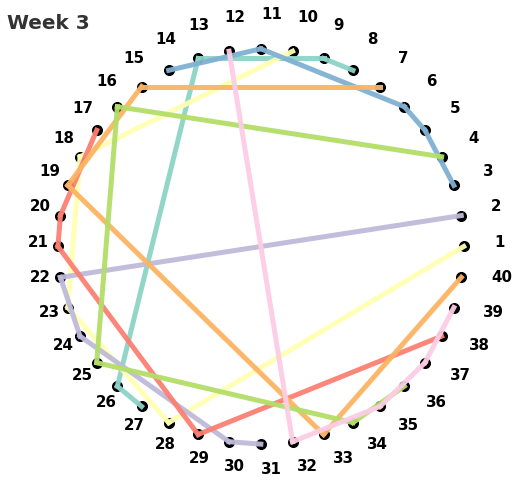

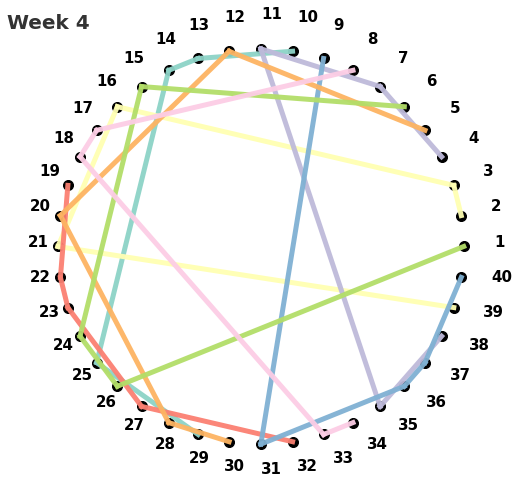

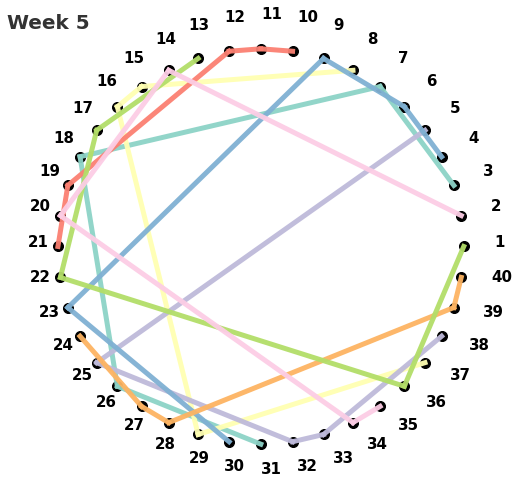

In [6]:
theta=np.linspace(0,2*np.pi,n+1)
R=20    

for w in instance.w:    
    plt.figure(figsize=(8,8))
    for g in instance.g:
        a=[i for i in instance.i  if value(instance.x[i,g,w]) >0 ]
        for p in range(int(n/G)-1):
            x1=R*np.cos(theta[a[p]])
            y1=R*np.sin(theta[a[p]])
            x2=R*np.cos(theta[a[p+1]])
            y2=R*np.sin(theta[a[p+1]])
            plt.plot((x1,x2),(y1,y2),c=K[g-1] , lw=5 , alpha=0.95)

    for i in instance.i:
        x=R*np.cos(theta[i-1])
        y=R*np.sin(theta[i-1])
        plt.scatter(x,y,s=100, c='k') 
        plt.text(x*1.15,y*1.15,s=str(i), fontsize=15,fontweight='bold')
    plt.text(-25,22,s='Week '+str(w), fontsize=20, fontweight='bold', alpha=0.8)

    plt.axis('off')
    
    plt.savefig('Golfer '+str(w)+' group .png', format='png', bbox_inches='tight', dpi=500)


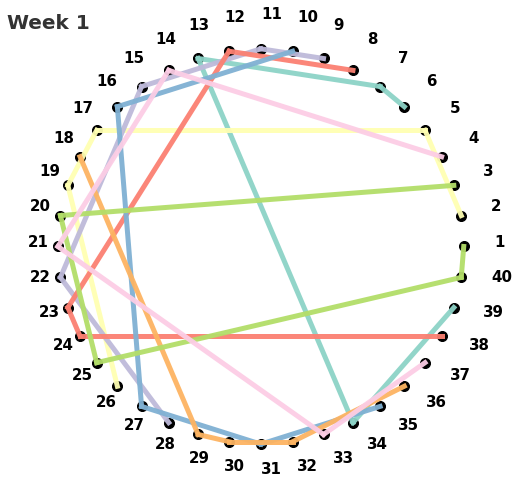

In [7]:
theta=np.linspace(0,2*np.pi,n+1)
R=20    

#for w in instance.w:  
w=1
plt.figure(figsize=(8,8))

for i in instance.i:
    x=R*np.cos(theta[i-1])
    y=R*np.sin(theta[i-1])
    plt.scatter(x,y,s=100, c='k') 
    plt.text(x*1.15,y*1.15,s=str(i), fontsize=15,fontweight='bold')
plt.text(-25,22,s='Week '+str(w), fontsize=20, fontweight='bold', alpha=0.8)



for g in instance.g:
    a=[i for i in instance.i  if value(instance.x[i,g,w]) >0 ]
    for p in range(int(n/G)-1):
        x1=R*np.cos(theta[a[p]])
        y1=R*np.sin(theta[a[p]])
        x2=R*np.cos(theta[a[p+1]])
        y2=R*np.sin(theta[a[p+1]])
        plt.plot((x1,x2),(y1,y2),c=K[g-1] , lw=5 , alpha=0.95)
        plt.axis('off')
        plt.savefig('gradually '+str(g)+str(p)+' group .png', format='png', bbox_inches='tight', dpi=500)
